In [18]:
import faulthandler
faulthandler.enable()

import gc
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score, 
    accuracy_score, 
    precision_score, 
    recall_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [19]:
def plot_learning_curves(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Graph of losses.
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Graph of accuracy.
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greens', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
# Setting up the device for training (Apple GPU or CPU).
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Running on", device)

Running on mps


In [22]:
data_dir = 'dataset/Intel_Image_Classification/'

In [23]:
# Preparing for transformation.
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((150, 150)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),            # Data Augmentation: Random cutting.
        transforms.RandomHorizontalFlip(),                              # Data Augmentation: Random horizontal flip.
        #transforms.RandomRotation(10),                                 # Data Augmentation: Random rotation.
        #transforms.ColorJitter(brightness=0.2, contrast=0.2),          # Data Augmentation: Change brightness and contrast.
        #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),       # Data Augmentation: Add a random offset.
        #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)), # Data Augmentation: Gaussian Blur.
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5),                               # Data Augmentation: Randomly delete parts of an image.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [24]:
# Download training and test kits.
train_data = datasets.ImageFolder(root=os.path.join(data_dir, 'seg_train/seg_train'), transform=data_transforms['train'])
test_data = datasets.ImageFolder(root=os.path.join(data_dir, 'seg_test/seg_test'), transform=data_transforms['val_test'])

In [25]:
# Separation into training and validation sets.
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [26]:
# Loading data into the DataLoader.
batch_size = 256
num_workers = 16
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

In [27]:
# Getting the dimensions of datasets.
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_data)
}
dataset_sizes

{'train': 11227, 'val': 2807, 'test': 3000}

In [28]:
class_names = train_data.classes
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [29]:
# Downloading a pre-trained ResNet18 model.
#model = models.resnet18(pretrained=True)
model = models.resnet50(pretrained=True)
#model = models.resnet18(weights='IMAGENET1K_V1')
number_of_classes = 6

# Freeze model layers.
for param in model.parameters():
    param.requires_grad = False

# Modifying the last layer.
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, number_of_classes)  # 6 classes for classification.

"""
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # New fully connected layer.
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),  # Dropout to prevent overlearning.
    nn.Linear(512, number_of_classes)  # Outer layer.
)
"""
"""
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),          # The first hidden layer.
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),               # The second hidden layer.
    nn.ReLU(),
    nn.Dropout(0.1),                   # Less Dropout to save information.
    nn.Linear(256, number_of_classes)  # Outer layer.
)
"""

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),          # The first hidden layer.
    nn.BatchNorm1d(512),               # NEW: Batch normalization.
    nn.LeakyReLU(0.01),
    nn.Dropout(0.2),                   # NEW: Less Dropout to save information.
    nn.Linear(512, 256),               # The second hidden layer.
    nn.BatchNorm1d(256),              # NEW: Batch normalization.
    nn.LeakyReLU(0.01),
    nn.Dropout(0.1),                   # Less Dropout to save information.
    nn.Linear(256, number_of_classes)  # Outer layer.
)

"""
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.LeakyReLU(0.01),  # LeakyReLU with a slight slope.
    nn.Dropout(0.5),
    nn.Linear(512, number_of_classes)
)
"""

model = model.to(device)

In [30]:
# Loss function.
criterion = nn.CrossEntropyLoss()

# Optimiser (for the last layer only).
#optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-04)

# Create a scheduler.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_acc = 0.0
    best_model_wts = model.state_dict()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keeping the best model alive.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

            # Saving results for graphs.
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

        # Calling the scheduler based on a validation loss
        scheduler.step(epoch_loss)  # Call based on a validation loss
    
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Model training.
model_trained, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

# Saving the best model.
torch.save(model_trained.state_dict(), 'best_resnet50_model.pth')


Epoch 1/15
----------
train Loss: 0.7633 Acc: 0.7859
val Loss: 0.4270 Acc: 0.8888

Epoch 2/15
----------
train Loss: 0.3828 Acc: 0.8904
val Loss: 0.3276 Acc: 0.8956

Epoch 3/15
----------
train Loss: 0.3188 Acc: 0.9013
val Loss: 0.2879 Acc: 0.9063

Epoch 4/15
----------
train Loss: 0.2875 Acc: 0.9081
val Loss: 0.2739 Acc: 0.9056

Epoch 5/15
----------
train Loss: 0.2711 Acc: 0.9105
val Loss: 0.2622 Acc: 0.9102

Epoch 6/15
----------
train Loss: 0.2537 Acc: 0.9140
val Loss: 0.2528 Acc: 0.9106

Epoch 7/15
----------
train Loss: 0.2374 Acc: 0.9213
val Loss: 0.2614 Acc: 0.9084

Epoch 8/15
----------
train Loss: 0.2307 Acc: 0.9209
val Loss: 0.2482 Acc: 0.9099

Epoch 9/15
----------
train Loss: 0.2188 Acc: 0.9266
val Loss: 0.2413 Acc: 0.9081

Epoch 10/15
----------
train Loss: 0.2138 Acc: 0.9258
val Loss: 0.2551 Acc: 0.9109

Epoch 11/15
----------
train Loss: 0.2070 Acc: 0.9276
val Loss: 0.2249 Acc: 0.9191

Epoch 12/15
----------
train Loss: 0.2003 Acc: 0.9305
val Loss: 0.2299 Acc: 0.9120



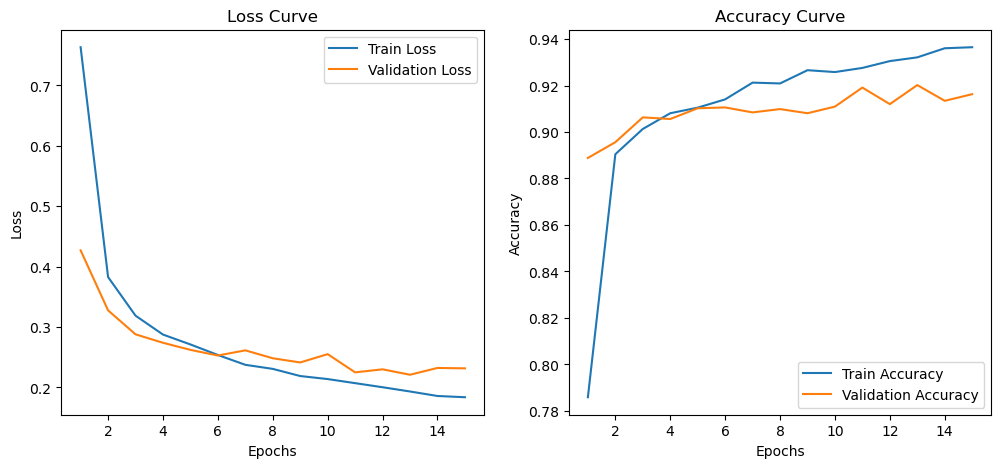

In [32]:
# Graphing learning curves.
plot_learning_curves(train_loss, val_loss, train_acc, val_acc)

Accuracy: 0.9207
Precision (weighted): 0.9226
Recall (weighted): 0.9207
F1-Score (weighted): 0.9199

Detailed Classification Report:
              precision    recall  f1-score   support

   buildings       0.96      0.90      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.93      0.79      0.85       553
    mountain       0.83      0.91      0.87       525
         sea       0.92      0.98      0.95       510
      street       0.92      0.96      0.94       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



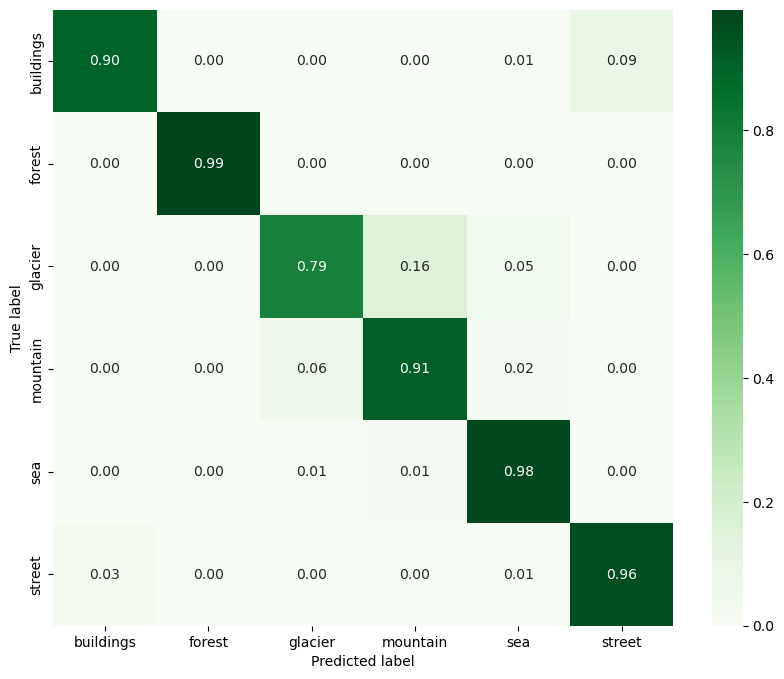

In [33]:
# Evaluation of the model on the test set.
def evaluate_model_with_metrics(model):
    model.eval()
    y_true = []
    y_pred = []

    # Collecting real and predicted labels.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Calculating metrics.
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Metrics output.
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")

    # Display a detailed classification report.
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Building an error matrix.
    plot_confusion_matrix(y_true, y_pred, class_names)

# Evaluation of the model on the test set.
evaluate_model_with_metrics(model_trained)

In [34]:
gc.collect()

14787

**Висновки з результатів тренування:**

*1. Загальна точність і продуктивність*
- Загальна точність (Accuracy: 0.9207) — це хороший результат, який вказує на правильну класифікацію приблизно 92% зразків на тестових даних.
- Precision (weighted): 0.9226, Recall (weighted): 0.9207, F1-Score (weighted): 0.9199 також демонструють стабільну продуктивність на всіх класах.
- Best validation accuracy досягнута на рівні 0.9202 на 13-й епосі, що свідчить про стабілізацію моделі до кінця навчання.

*2. Тренувальні та валідаційні криві*
- Спостерігається поступове зниження тренувальних втрат і одночасне підвищення тренувальної точності, що свідчить про те, що модель добре навчається на тренувальних даних.
- Валідаційні втрати стабілізувалися після 10-ї епохи, і валідаційна точність також демонструє стабільність з 10-ї епохи. Це свідчить про те, що модель не перенавчається, хоча спостерігається незначне покращення продуктивності на останніх епохах.

*3. Класифікація по класах*
- Buildings (Precision: 0.96, Recall: 0.90): Дуже хороша точність, але чутливість трохи нижча, що свідчить про те, що деякі приклади класу “buildings” пропускаються або плутаються з іншими класами.
- Forest (Precision: 0.99, Recall: 0.99): Високі значення precision та recall, що вказує на відмінну класифікацію цього класу.
- Glacier (Precision: 0.93, Recall: 0.79): Низька чутливість у цьому класі (0.79) вказує на те, що модель пропускає значну частину прикладів цього класу або плутає їх з іншими класами.
- Mountain (Precision: 0.83, Recall: 0.91): Тут спостерігається висока чутливість, але точність трохи нижча, що означає, що деякі передбачення для “mountain” можуть бути помилковими позитивами.
- Sea (Precision: 0.92, Recall: 0.98): Відмінні результати для цього класу з високими показниками precision та recall, що вказує на стабільну класифікацію.
- Street (Precision: 0.92, Recall: 0.96): Хороші результати для цього класу, що свідчить про те, що більшість прикладів цього класу класифікуються правильно.

*4. Проблемні класи*
- Класи glacier та mountain демонструють проблеми. У випадку “glacier”, низький показник recall (0.79) вказує на те, що модель часто плутає зразки цього класу з іншими класами. Це може бути пов’язано з тим, що “glacier” і “mountain” можуть мати схожі візуальні риси.
- Можливо, варто зосередитись на поліпшенні розпізнавання саме цих двох класів.

**Рекомендації для покращення:**

*1. Балансування класів або зважена функція втрат*
- Оскільки “glacier” має проблеми з класифікацією, можна спробувати використовувати зважену функцію втрат, щоб дати більшу вагу цьому класу під час навчання. Це може допомогти моделі краще розпізнавати цей клас.

- Використання зваженої функції втрат  
```
class_weights = torch.tensor([1.0, 0.9, 1.3, 1.1, 0.9, 0.95], device=device) criterion = nn.CrossEntropyLoss(weight=class_weights)
```

*2. Тонке налаштування більше шарів*

Зараз усі шари, окрім останніх, заморожені. Можна розморозити більше шарів базової моделі (наприклад, layer4), щоб дозволити моделі краще адаптуватися до вашого специфічного набору даних.
```
for param in model.layer4.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Враховуємо більше шарів
```

*3. Додаткова аугментація для складних класів*

- Варто спробувати більш складну аугментацію даних для класів, таких як “glacier” і “mountain”, щоб покращити здатність моделі розрізняти їх: Додати RandomRotation, RandomErasing або інші техніки для створення більшого різноманіття зображень для цих класів.

*4. Збільшення кількості епох*

- Модель все ще показує позитивний тренд у зниженні тренувальних втрат. Можна збільшити кількість епох до 20 або навіть більше, щоб дати моделі більше часу для навчання. Але використовуйте early stopping, щоб уникнути перенавчання.

*5. Тонка настройка learning rate*

- Зараз у вас використовується ReduceLROnPlateau для зниження learning rate. Можливо, варто зменшити початковий learning rate або знизити його швидше.

**Висновок:**
- Модель вже демонструє хороші результати, але можна покращити продуктивність для класів “glacier” та “mountain”.
- Використання зваженої функції втрат, розширеної аугментації та тонкого налаштування додаткових шарів може дати кращі результати.
- Модель стабільно навчається, і збільшення кількості епох або зниження learning rate може допомогти досягти ще кращої продуктивності.